#### <center><strong style="color:#363062">Rainfall Forecast</strong></center>

##### <strong style="color:#ff9717"><em>Tiền xử lý dữ liệu</em></strong>

In [725]:
# Import library

import pandas as pd
import matplotlib.pyplot as plt 

In [726]:
# Read data

date_col = 'Date'
rainfall_col = 'RF_LeThuy'

df = pd.read_csv('data.csv')
df = pd.DataFrame({ 'Date': df[date_col], 'Rainfall': df[rainfall_col] })
# df = df[13505:]

In [727]:
# Set the correct data type

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
df['Rainfall'] = pd.to_numeric(df['Rainfall'], errors='coerce')

In [728]:
# Display missing value

for i in range(len(df.columns)):
  missing_data = df[df.columns[i]].isna().sum()
  perc = missing_data / len(df) * 100
  print(f'> Columns {i}[{df.columns[i]}][{df[df.columns[i]].dtypes}]' + 
        f' missing entries: {missing_data}, percentage {perc}%')

> Columns 0[Date][datetime64[ns]] missing entries: 0, percentage 0.0%
> Columns 1[Rainfall][float64] missing entries: 3, percentage 0.018667164457718873%


In [729]:
# Replace 'x' = mode_value

mode_value = df['Rainfall'].mode()[0]
df['Rainfall'].fillna(mode_value, inplace=True)

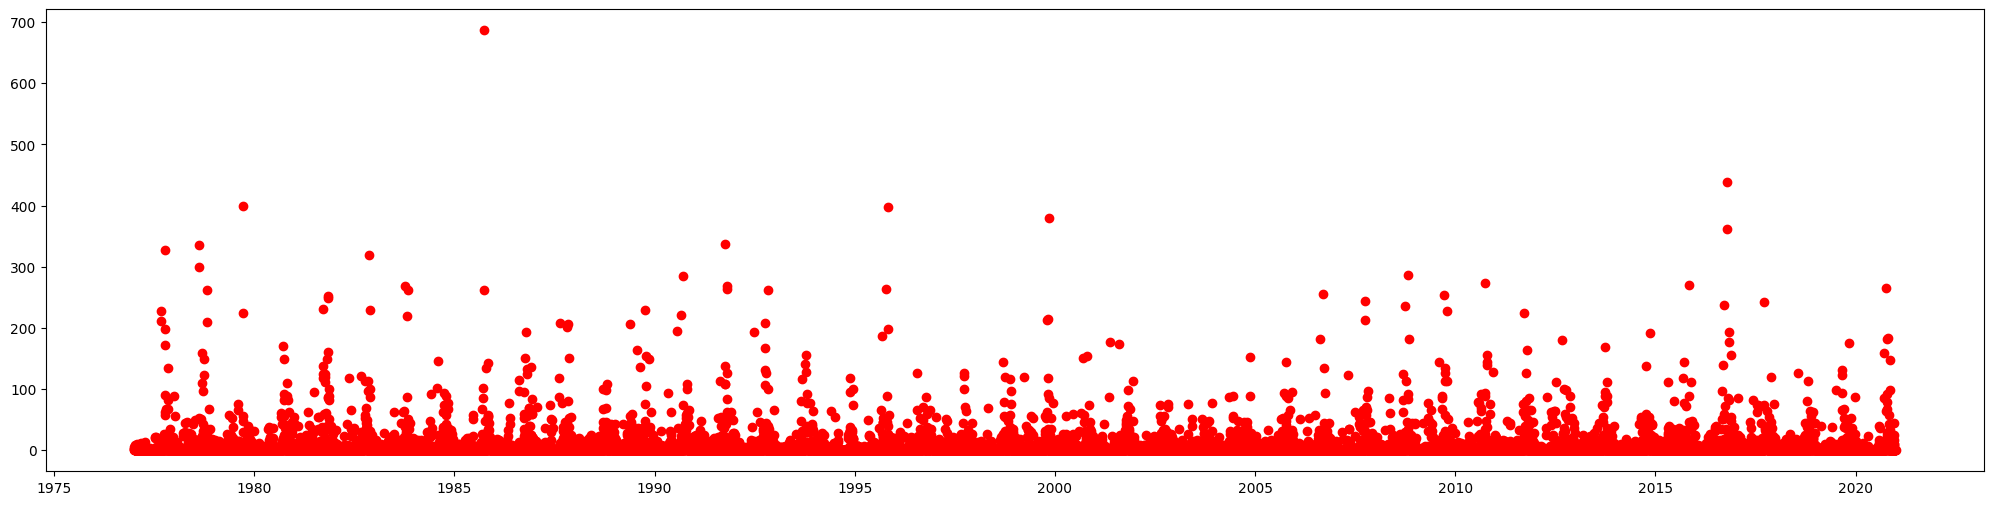

In [730]:
ngay_index = list(range(len(df['Date'])))

# Tạo biểu đồ phân tán
plt.figure(figsize=(25, 6))
plt.scatter(df['Date'], df['Rainfall'], c='red', marker='o', label='Lượng mưa')
# plt.xticks(df['Date'], ngay, rotation=45)
# plt.xlabel('Ngày')
# plt.ylabel('Lượng mưa (mm)')
# plt.title('Biểu đồ Lượng mưa theo Ngày')
# plt.grid(True)
# plt.legend()

# Hiển thị biểu đồ
plt.show()

In [731]:
# df = df[12775:]

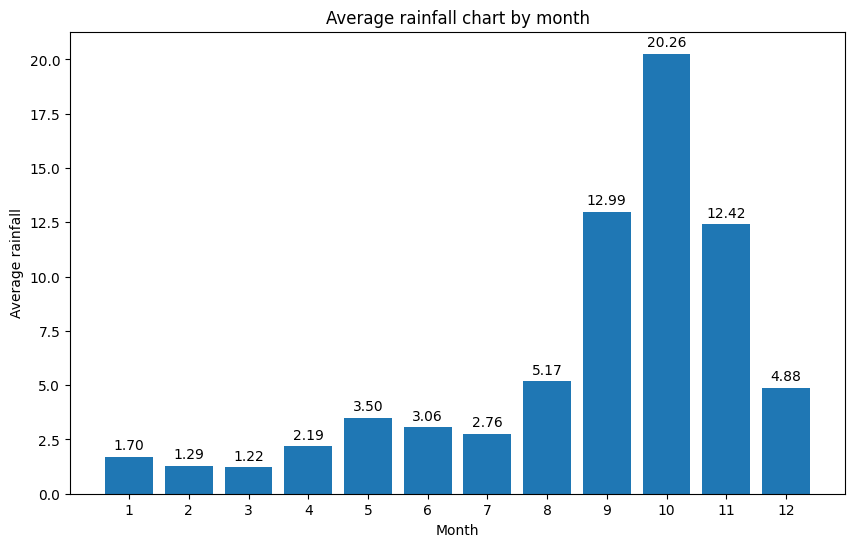

In [732]:
df['Month'] = df['Date'].dt.month
monthly_avg = df.groupby('Month')['Rainfall'].mean()

# Show chart
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_avg.index, monthly_avg.values)
plt.xlabel('Month')
plt.ylabel('Average rainfall')
plt.title('Average rainfall chart by month')

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.xticks(range(1, 13))
plt.show()

In [733]:
# Split data from month


data = df[df['Month'].between(8, 12)].copy()
data = data[data['Rainfall'] <= 250]
# data = df.copy()


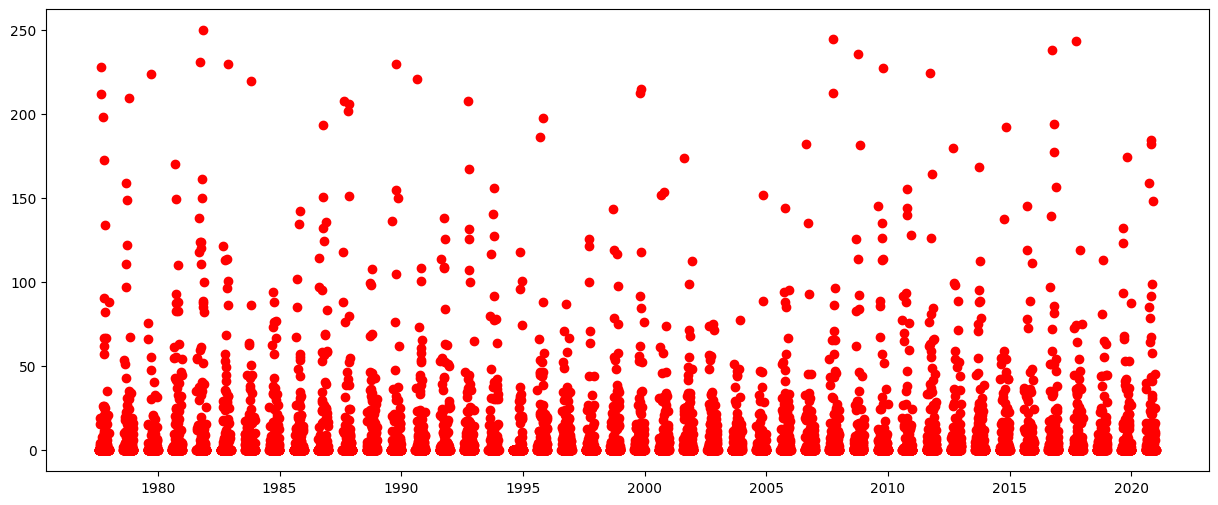

In [734]:
ngay_index = list(range(len(data['Date'])))

# Tạo biểu đồ phân tán
plt.figure(figsize=(15, 6))
plt.scatter(data['Date'], data['Rainfall'], c='red', marker='o', label='Lượng mưa')
# plt.xticks(df['Date'], ngay, rotation=45)
# plt.xlabel('Ngày')
# plt.ylabel('Lượng mưa (mm)')
# plt.title('Biểu đồ Lượng mưa theo Ngày')
# plt.grid(True)
# plt.legend()

# Hiển thị biểu đồ
plt.show()

In [735]:
data.drop(columns=['Date', 'Month'], axis=1, inplace=True)

In [736]:
# Categorize the data into 4 levels
import numpy as np

def CategorizeRainFall(x):
  if (x < 20): return 0
  # elif ( x < 20): return 1
  elif ( x < 64.5): return 1
  elif ( x < 124.5): return 2
  else: return 3


data['Rainfall'] = pd.to_numeric(data['Rainfall'], errors='coerce')
# data['Rainfall'] = data['Rainfall'].apply(CategorizeRainFall)
data.dropna(subset=['Rainfall'], inplace=True)

In [737]:
# # df['Month'] = df['Date'].dt.month
# monthly_avg = data.groupby('Month')['Rainfall'].mean()

# # Show chart
# plt.figure(figsize=(10, 6))
# bars = plt.bar(monthly_avg.index, monthly_avg.values)
# plt.xlabel('Month')
# plt.ylabel('Average rainfall')
# plt.title('Average rainfall chart by month')

# for bar in bars:
#     height = bar.get_height()
#     plt.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# plt.xticks(range(1, 13))
# plt.show()

In [738]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix
import seaborn as sns

def ScoreSVM(X, y):
  # SVM = SVC(kernel = 'sigmoid')
  SVM = SVC(kernel='sigmoid' ,decision_function_shape='ovr')
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
  SVM.fit(X_train, y_train)
  y_pred = SVM.predict(X_test)
  # return classification_report(y_test, y_pred, zero_division=1)
  print(classification_report(y_test, y_pred, zero_division=1))
  precision, recall, f1_core ,support = precision_recall_fscore_support(y_test, y_pred, average='macro')
  accuracy = accuracy_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)

  # Hiển thị ma trận nhầm lẫn bằng heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()
  return precision, recall, f1_core ,support, accuracy

In [739]:
def ProcessData(data, days):
  dt = data.copy() 
  for i in range(days + 1):
    dt[f'{i} Days Before'] = dt['Rainfall'].shift(-i)
  dt = dt[:-days]
  X = dt.drop(columns = ['Rainfall', '0 Days Before'], axis = 1)
  y = dt['Rainfall']
  return X, y

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1167
           1       0.14      0.04      0.06       123
           2       0.29      0.19      0.23        31
           3       0.00      0.00      1.00        16

    accuracy                           0.85      1337
   macro avg       0.33      0.30      0.55      1337
weighted avg       0.79      0.85      0.82      1337



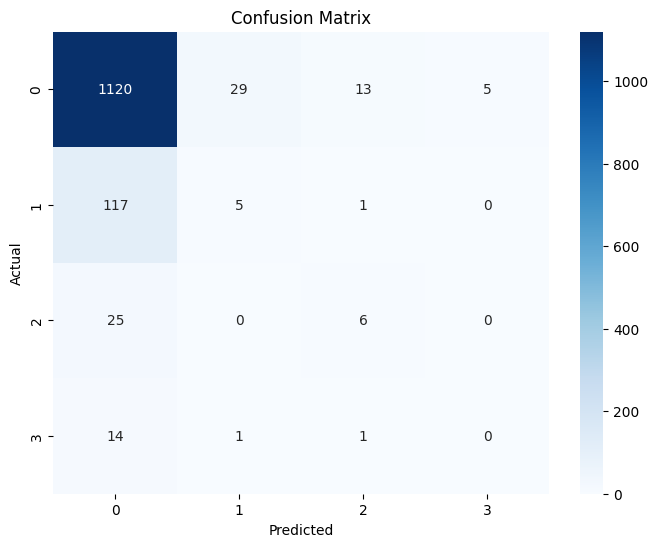

In [740]:
res = pd.DataFrame(columns=['Days', 'Precision','Recall', 'F1-Score', 'Support', 'Accuracy'])
# for i in range(2, 30):
num = 21

X, y = ProcessData(data, num)
y = y.apply(CategorizeRainFall)

precision, recall, f1_score, support, accuracy = ScoreSVM(X, y)
# res.loc[i] = [i, precision, recall, f1_score, support, accuracy]
# res

In [741]:
# from keras.utils import to_categorical
# from sklearn.model_selection import train_test_split

# # Chuyển đổi nhãn thành mã hóa one-hot
# y_encoded = to_categorical(y, num_classes=4)

# # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# model = Sequential()
# model.add(LSTM(50, input_shape=(num, 1)))
# model.add(Dense(4, activation='softmax'))  # Lớp đầu ra với activation 'softmax' cho phân loại thành 4 lớp
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.fit(X_train, y_train, epochs=50, batch_size=32)

# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)

# from sklearn.metrics import classification_report
# print(classification_report(y_true, y_pred_classes))

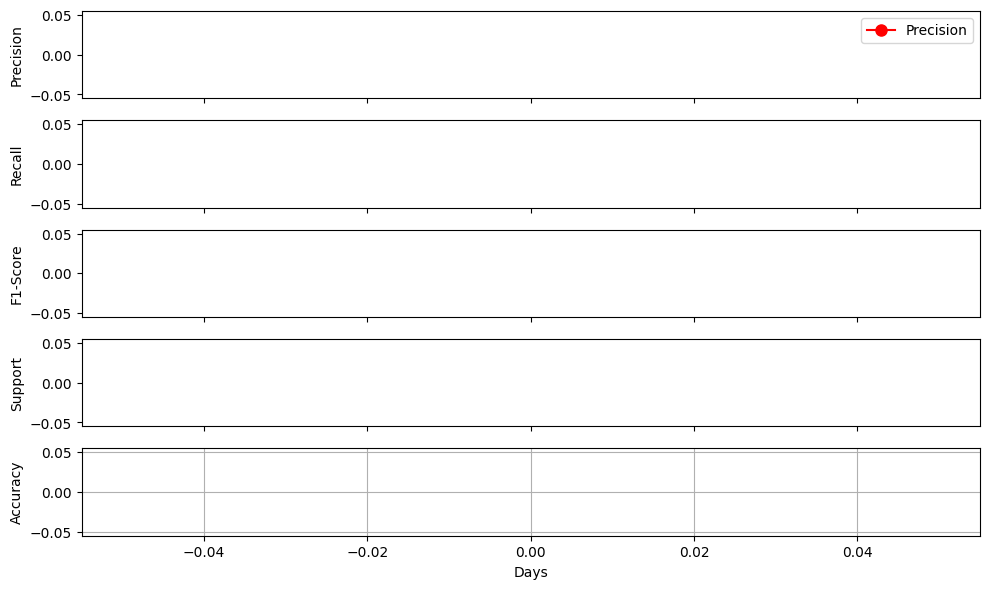

In [742]:
import matplotlib.pyplot as plt

# Giả sử res là DataFrame chứa các độ đo (precision, recall, f1-score, support, accuracy)
# Các cột trong res: 'Days', 'Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy'

# Chọn màu và ký hiệu cho điểm và đường nối
dot_color = 'red'
line_color = 'blue'
dot_marker = 'o'

# Tạo bảng biểu đồ
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 6), sharex=True)

# Đặt tên cho các đường trong biểu đồ
lines = ['Precision', 'Recall', 'F1-Score', 'Support', 'Accuracy']

# Lặp qua từng độ đo và vẽ biểu đồ tương ứng
for i, line in enumerate(lines):
    # Điểm
    axes[i].plot(res['Days'], res[line], marker=dot_marker, markersize=8, color=dot_color, label=line)
    
    # Đường nối
    axes[i].plot(res['Days'], res[line], linestyle='-', linewidth=2, color=line_color)
    
    # Đặt nhãn cho trục y cho biểu đồ hiện tại
    axes[i].set_ylabel(line)

# Đặt nhãn cho trục x (chung cho tất cả biểu đồ)
axes[4].set_xlabel('Days')

# Hiển thị chú thích (legend)
axes[0].legend()

# Hiển thị biểu đồ
plt.grid(True)
plt.tight_layout()
plt.show()
